In [1]:

import numpy as np 
import pandas as pd
import os
import pathlib
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
dir = os.listdir("C:\\Users\\Karthik\\Downloads\\archive (1)\PlantVillage")
for filenames in dir:
    print(filenames)



diesease
Pepper__bell___Bacterial_spot
Pepper__bell___healthy
Potato___Early_blight
Potato___healthy
Potato___Late_blight
Tomato_healthy
Tomato_Spider_mites_Two_spotted_spider_mite
Tomato__Tomato_mosaic_virus
Tomato__Tomato_YellowLeaf__Curl_Virus


Diseases in tomato plants can be classified into the one of the following categories:
1. Tomato_Leaf_Mold
2. Tomato__Tomato_YellowLeaf__Curl_Virus
3. Tomato_Bacterial_spot
4. Tomato_Septoria_leaf_spot
5. Tomato_healthy
6. Tomato_Spider_mites_Two_spotted_spider_mite
7. Tomato_Early_blight
8. Tomato__Target_Spot
9. Tomato_Late_blight
10. Tomato__Tomato_mosaic_virus

The idea is to build a deep learning model with the given image dataset in order to successfully predict the type of tomato leaf disease.
In this notebook I have taken image dataset for 6/10 of these diseases:
1. Tomato_Bacterial_spot
2. Tomato_Early_blight
3. Tomato_Late_blight
4. Tomato_Leaf_Mold
5. Tomato_Septoria_leaf_spot
6. Tomato__Target_Spot

In [2]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [5]:
# Seperating all the tomato leaf disease dataset into /kaggle/working
!cp -rf ../input/plant-village/PlantVillage/Tomato_Bacterial_spot ./Tomato_Bacterial_spot

'cp' is not recognized as an internal or external command,
operable program or batch file.


In [4]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Early_blight ./Tomato_Early_blight

In [5]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Late_blight ./Tomato_Late_blight 

In [6]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Leaf_Mold ./Tomato_Leaf_Mold

In [7]:
!cp -rf ../input/plant-village/PlantVillage/Tomato_Septoria_leaf_spot ./Tomato_Septoria_leaf_spot

In [8]:
!cp -rf ../input/plant-village/PlantVillage/Tomato__Target_Spot ./Tomato__Target_Spot

In [9]:
#!cp -rf ../input/plant-village/PlantVillage/Tomato_Spider_mites_Two_spotted_spider_mite ./Tomato_Spider_mites_Two_spotted_spider_mite

In [10]:
#!cp -rf ../input/plant-village/PlantVillage/Tomato__Tomato_YellowLeaf__Curl_Virus ./Tomato__Tomato_YellowLeaf__Curl_Virus

In [11]:
#!cp -rf ../input/plant-village/PlantVillage/Tomato__Tomato_mosaic_virus ./Tomato__Tomato_mosaic_virus

In [12]:
#!cp -rf ../input/plant-village/PlantVillage/Tomato_healthy ./Tomato_healthy

### Reading images in batches with tf dataset

In [3]:
dataset_dir="C:\\Users\\Karthik\\Downloads\\archive (1)\\PlantVillage\\diesease"

In [4]:
IMAGE_SIZE = 256
BATCH_SIZE = 32

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    directory = dataset_dir,
    shuffle = True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)


Found 9163 files belonging to 6 classes.


In [5]:
class_names = dataset.class_names
class_names

['Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato__Target_Spot']

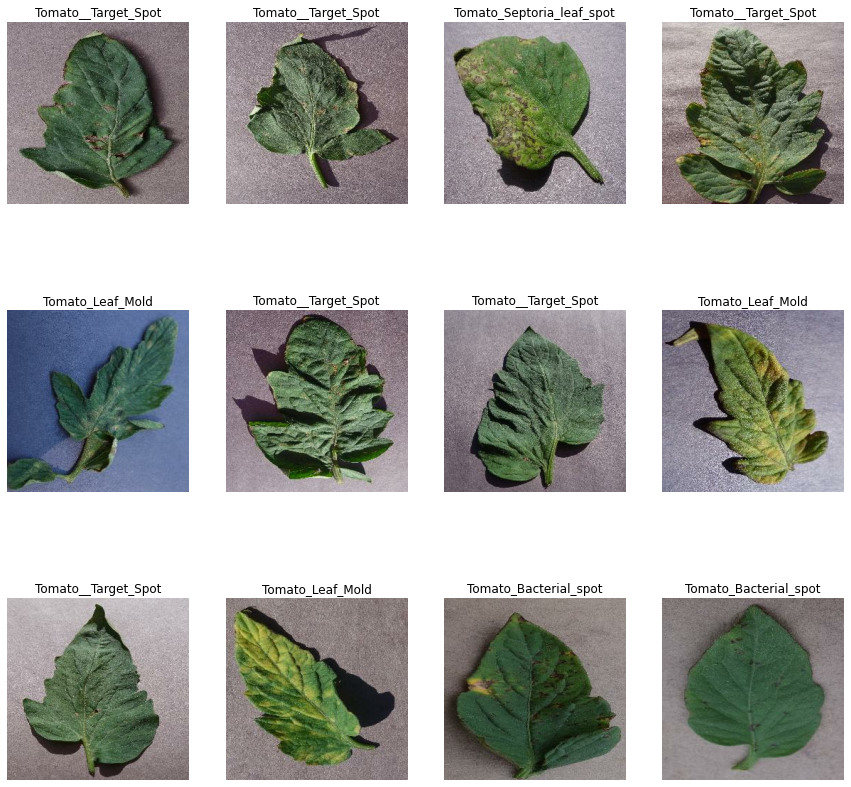

In [6]:
plt.figure(figsize=(15,15))
for image_batch, label_data in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_data[i]])
        plt.axis('off')

## Splitting into test and train dataset
### I have taken training set = 80%, remaining 20% ==> 10% is used for validation, 10% is used for test

In [7]:
#defining a function to split dataset into train, test and val dataset
def get_partition_ds(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle_=True, shuffle_size=10000):
    ds_len = len(ds)
    
    if shuffle_:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    ds_train = int(ds_len*train_split)
    train_dataset = ds.take(ds_train)
    test = ds.skip(ds_train)
    ds_val = int(ds_len*val_split)
    val_dataset = test.take(ds_val)
    test_dataset = test.skip(ds_val)
    
    return train_dataset, val_dataset, test_dataset

train_dataset, val_dataset, test_dataset = get_partition_ds(dataset)

In [8]:
print("Train data len:",len(train_dataset),"\nVal data len:",len(val_dataset),"\nTest data len: ",len(test_dataset))

Train data len: 229 
Val data len: 28 
Test data len:  30


### Cache, Shuffle, and Prefetch the Dataset

In [9]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building Model

#### Here, firstly I am resizing the image again to 256x256 px. The images in dataset are already in that size but, if someone supplies image of different size this will take care of it. Also, normalization is done to improve model performance by dividing pixel values by 256 to get a range of (0,1)

In [10]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1./255)
])

In [11]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [12]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Model Architecture

Using CNN and softmax activation in the output layer, also adding the resize, rescale and data augmentation layer


In [19]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, 3)
n_classes = 7 # number of classes of tomato leaves disease
 
model1 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model1.build(input_shape=input_shape)

In [20]:
model1.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [21]:
stats = model1.fit(
    train_dataset,
    batch_size = BATCH_SIZE,
    validation_data = val_dataset,
    verbose = 1,
    epochs = 25
)

Epoch 1/25
229/229 [==============================] - 311s 1s/step - loss: 1.5900 - accuracy: 0.4808 - val_loss: 1.1148 - val_accuracy: 0.5692
Epoch 2/25
229/229 [==============================] - 292s 1s/step - loss: 0.9455 - accuracy: 0.6443 - val_loss: 0.9071 - val_accuracy: 0.6440
Epoch 3/25
229/229 [==============================] - 292s 1s/step - loss: 0.7191 - accuracy: 0.7319 - val_loss: 0.7870 - val_accuracy: 0.7132
Epoch 4/25
229/229 [==============================] - 286s 1s/step - loss: 0.6569 - accuracy: 0.7542 - val_loss: 0.6306 - val_accuracy: 0.7679
Epoch 5/25
229/229 [==============================] - 281s 1s/step - loss: 0.5947 - accuracy: 0.7797 - val_loss: 0.5977 - val_accuracy: 0.7679
Epoch 6/25
229/229 [==============================] - 286s 1s/step - loss: 0.5214 - accuracy: 0.8088 - val_loss: 0.8018 - val_accuracy: 0.7400
Epoch 7/25
229/229 [==============================] - 290s 1s/step - loss: 0.4922 - accuracy: 0.8192 - val_loss: 0.5079 - val_accuracy: 0.8181

In [22]:
scores = model1.evaluate(test_dataset)

30/30 [==============================] - 29s 438ms/step - loss: 0.1743 - accuracy: 0.9372


In [23]:
scores

[0.17428883910179138, 0.937167227268219]

## Plotting Accuracy v Loss Curves

In [24]:
acc = stats.history['accuracy']
val_acc = stats.history['val_accuracy']

loss = stats.history['loss']
val_loss = stats.history['val_loss']

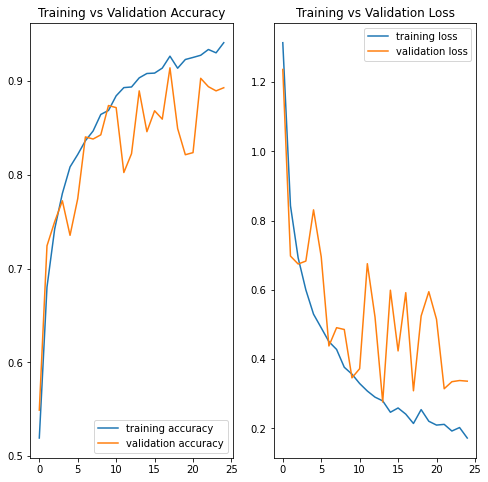

In [30]:
EPOCHS = 25

plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),acc,label='training accuracy')
plt.plot(range(EPOCHS),val_acc,label='validation accuracy')
plt.legend()
plt.title("Training vs Validation Accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS),loss,label='training loss')
plt.plot(range(EPOCHS),val_loss,label='validation loss')
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

## Running prediction on images

Image to predict
Actual Label:  Tomato_Septoria_leaf_spot
1/1 [==============================] - 1s 1s/step
Predicted Label:  Tomato_Septoria_leaf_spot


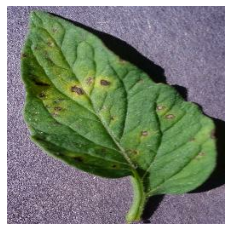

In [25]:
import numpy as np
for image_batch,label_batch in test_dataset.take(1):
    first_img = image_batch[0].numpy().astype("uint8")
    first_label = label_batch[0].numpy()
    
    print("Image to predict")
    plt.imshow(first_img)
    print("Actual Label: ",class_names[first_label])
    
    batch_prediction = model1.predict(image_batch)
    print("Predicted Label: ",class_names[np.argmax(batch_prediction[0])])
    plt.axis("off")

### Making a function to return predicted label and confidence for an image

In [31]:
def predict_model(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 74ms/step


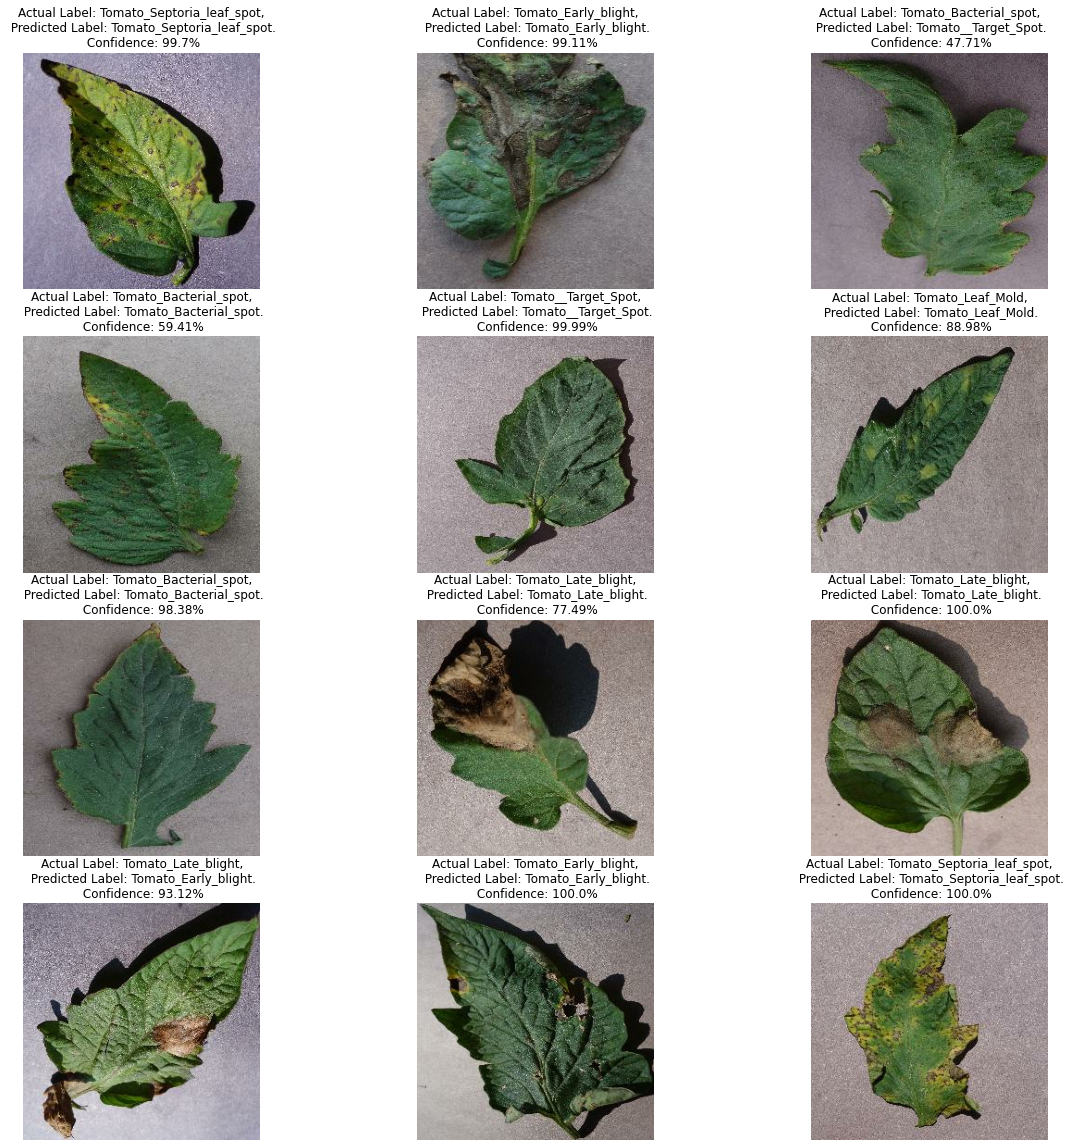

In [32]:
plt.figure(figsize=(20,20))
for images,label in test_dataset.take(1):
    for i in range(12):
        plt.subplot(4,3,i+1)
        predicted_label, confidence = predict_model(model1,images[i].numpy())
        plt.imshow(images[i].numpy().astype("uint8"))
        actual_class = class_names[label[i]] 
        plt.title(f"Actual Label: {actual_class},\n Predicted Label: {predicted_label}.\n Confidence: {confidence}%")
        plt.axis("off")

In [27]:
model1.save('saved_model/my_model')

Found untraced functions such as _jit_compiled_convolution_op, _jit_compiled_convolution_op while saving (showing 2 of 2). These functions will not be directly callable after loading.
Assets written to: saved_model/my_model\assets


In [29]:
mod=tf.keras.models.load_model("C:\\Users\\Karthik\\Downloads\\saved_model\\my_model")

In [30]:
p=mod.evaluate(test_dataset)
p

30/30 [==============================] - 14s 467ms/step - loss: 0.1743 - accuracy: 0.9372


[0.17428886890411377, 0.937167227268219]